In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import glac_mw.saving as saving
import glac_mw.routing as routing
import glac_mw.spreading as spreading
import glac_mw.plotting as plotting
import glac_mw.glac1d_toolbox as tb
import datetime

# Demonstration saving algorithm

**Objective** : Save routed discharge data_array to a netcdf dataset. Operations : 
- Create a netcdf dataset from a discharge array, a lsm and options.
- Transform an existing dataset to modify its options and save it.
- Save as a waterfix.

## Inputs

**Land Sea Mask** : experiment name <-> time table is available on GitHub.  

In [2]:
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')

lon_lsm, lat_lsm = ds_lsm.longitude.values, ds_lsm.latitude.values
lon_lsm_b, lat_lsm_b = tb.create_coordinate_edges(lon_lsm), tb.create_coordinate_edges(lat_lsm)
lsm = ds_lsm.lsm.values

ds_lsm

<xarray.Dataset>
Dimensions:     (latitude: 144, longitude: 288)
Coordinates:
  * longitude   (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * latitude    (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
Data variables:
    lsm         (latitude, longitude) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    depthlevel  (latitude, longitude) float32 ...
    depthdepth  (latitude, longitude) float32 ...
Attributes:
    title:    Produced using writenc6 program by PJV

Text(0.5, 1.0, 'Land sea mask at 21 kya')

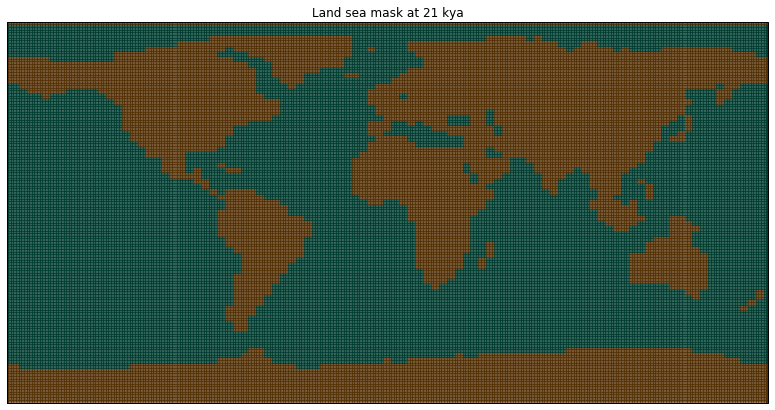

In [3]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(), cmap="BrBG_r", alpha=0.8)
axMap.set_global()
axMap.set_title("Land sea mask at 21 kya")

**Waterfix** : 2 dimenstion [lat*lon] hadcm3 meltwater discharge

In [4]:
ds_wfix = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.waterfix.nc')

lon_wfix, lat_wfix = ds_wfix.longitude.values, ds_wfix.latitude.values
lon_wfix_b, lat_wfix_b = tb.create_coordinate_edges(lon_wfix), lat_wfix
wfix = ds_wfix.field672.isel(depth=0).isel(t=0)

ds_wfix

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 290, t: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 358.75 360.0 361.25
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * depth      (depth) float32 5.0
  * t          (t) object 1800-12-01 00:00:00
Data variables:
    field672   (t, depth, latitude, longitude) float32 ...
Attributes:
    history:  Thu Jan 18 08:19:59 GMT 2018 - CONVSH V1.91 16-February-2006

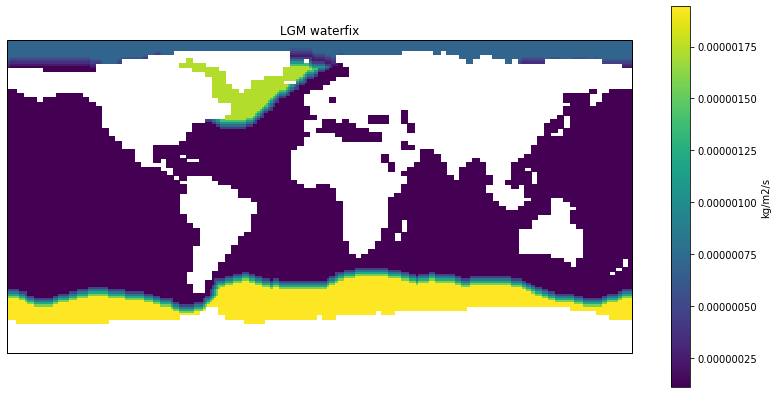

In [5]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_wfix_b, lat_wfix_b, wfix, transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

**Routed discharge files** : results of routing and spreading algorithm.

In [6]:
ds_hice = xr.open_dataset('/nfs/annie/eeymr/work/data/glac_mw/GLAC1DHiceF26.nc')
ds_pointer = xr.open_dataset('/nfs/annie/eeymr/work/data/glac_mw/GLAC1DdrainagePointerF26ka.nc')

routed_mw = routing.routing(ds_hice, ds_pointer, ds_lsm, mode_flux="Volume", mode_lon="double",
                            mode_shape="cross", mode_smooth="differential", t_debug=3)

spreaded_mw = spreading.spreading(routed_mw, ds_lsm, ds_wfix)

__ Routing algorithm
Reuse existing file: conservative_720x720_144x288.nc
____ Computation time step : 0.
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.
____ Computation time step : 1.
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.
____ Computation time step : 2.
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.
__ Spreading algorithm
____ Spreading in {'name': 'US_East_Coast', 'loc': 147 ocean cells in the region, 'region': 125 ocean cells in the region}
____ Spreading in {'name': 'Greenland_Arctic', 'loc': 163 ocean cells in the region, 'region': 163 ocean cells in the region}
____ Spreading in {'name': 'N_American_Arctic', 'loc': 390 ocean cells in the region, 'region': 355 ocean cells in the region}
____ Spreading in {'name': 'Gulf_of_Mexico', 'loc': 96 ocean c

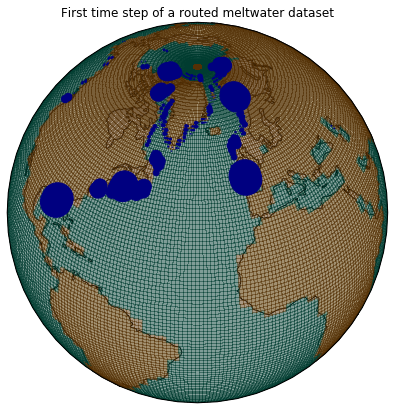

In [7]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)

x,y,s = plotting.scatter_mask(routed_mw[0])
axMap.scatter(lon_lsm[x], lat_lsm[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Saving method - Main method

The saving method will create the output directory and the netcdf waterfix according to input options.

In [8]:
saving.saving(routed_mw, ds_lsm, "temev", mode="routed", start_year=-26, end_year=-25.8, step=100, mode_smooth="diff")

saving.saving(spreaded_mw, ds_lsm, "temev", mode="spreaded", start_year=-26, end_year=-25.8, step=100, mode_smooth="diff")

__ Saving algorithm
____ Creating directory at  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff
____ Directory  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff  already exists.
__ Saving at: /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff/temev.discharge.glac_mw.nc
__ Saving algorithm
____ Creating directory at  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s
____ Directory  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s  already exists.
__ Saving at: /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s/temev.discharge.glac_mw.nc


In [9]:
# routed
ds = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff/temev.discharge.glac_mw.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 3)
Coordinates:
  * t          (t) float64 -2.6e+04 -2.59e+04 -2.58e+04
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -26
    end_year:     -25.8
    step:         100
    mode:         routed
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 19:28:55.502125 by Yvan Romé

In [10]:
# spreaded
ds = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s/temev.discharge.glac_mw.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 3)
Coordinates:
  * t          (t) float64 -2.6e+04 -2.59e+04 -2.58e+04
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -26
    end_year:     -25.8
    step:         100
    mode:         spreaded
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 19:28:55.756663 by Yvan Romé

## Correcting algorithm

The routing algorithm is asking for a lot of resources and it is more efficient to just crop an existing dataset to a new set of options.

In [11]:
ds = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff/temev.discharge.glac_mw.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 3)
Coordinates:
  * t          (t) float64 -2.6e+04 -2.59e+04 -2.58e+04
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -26
    end_year:     -25.8
    step:         100
    mode:         routed
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 19:28:55.502125 by Yvan Romé

In [12]:
# With a different time range
saving.correcting(ds, new_start_year=-26, new_end_year=-25.9)

__ Correction algorithm
____ Creating directory at  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.9_100.diff
____ Directory  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.9_100.diff  already exists.
__ Saving at: /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.9_100.diff/temev.discharge.glac_mw.nc


In [13]:
ds_out = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.9_100.diff/temev.discharge.glac_mw.nc", decode_times=False)
ds_out

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 2)
Coordinates:
  * t          (t) float64 -2.6e+04 -2.59e+04
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -26
    end_year:     -25.9
    step:         100
    mode:         routed
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 19:28:55.831177 by Yvan Romé

In [14]:
# Or a different time step
saving.correcting(ds, new_step=200)

__ Correction algorithm
____ Creating directory at  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_200.diff
____ Directory  /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_200.diff  already exists.
__ Saving at: /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_200.diff/temev.discharge.glac_mw.nc


In [15]:
ds_out = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_200.diff/temev.discharge.glac_mw.nc", decode_times=False)
ds_out

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 2)
Coordinates:
  * t          (t) float64 -26.0 174.0
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -26
    end_year:     -25.8
    step:         200
    mode:         routed
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 19:28:55.868362 by Yvan Romé

## Conversion to waterfix

In [16]:
ds = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s/temev.discharge.glac_mw.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 3)
Coordinates:
  * t          (t) float64 -2.6e+04 -2.59e+04 -2.58e+04
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:        Meltwater discharge for transient GLAC1D last delgaciation ...
    start_year:   -26
    end_year:     -25.8
    step:         100
    mode:         spreaded
    mode_smooth:  diff
    lsm:          temev
    history:      Created 2020-06-11 19:28:55.756663 by Yvan Romé

In [17]:
saving.to_waterfix(ds, ds_wfix)

__ Saving at: /nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s/temev.wfix.glac_mw.nc


In [18]:
ds_out = xr.open_dataset("/nfs/annie/eeymr/work/outputs/proj_glac_mw/glac.-26_-25.8_100.diff_s/temev.wfix.glac_mw.nc", decode_times=False)
ds_out

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 290, t: 3)
Coordinates:
  * t          (t) float64 -2.6e+04 -2.59e+04 -2.58e+04
  * depth      (depth) float32 5.0
  * latitude   (latitude) float32 -89.375 -88.125 -86.875 ... 88.125 89.375
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 358.75 360.0 361.25
Data variables:
    discharge  (t, depth, latitude, longitude) float64 ...
Attributes:
    title:    Waterfix for transient GLAC1D last delgaciation HadCM3 simulati...
    history:  Created 2020-06-11 19:28:55.963125 by Yvan Romé

## Drift patch - deprecated

In [ ]:
start_date, end_date = 4000, 5000
waterfix_patch = saving.calculate_patch("/nfs/see-fs-01_users/eeymr/dump2hold/xosfa/pg", 'xosfa', ds_wfix, start_date, end_date)

____ Computation of the drift patch


In [ ]:
new_wfix = saving.create_corrected_waterfix(waterfix_patch, ds_lsm, ds_wfix)
new_wfix

In [ ]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_wfix_b[:-2], lat_wfix_b, waterfix_patch*(1-lsm) , transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

In [ ]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_wfix_b, lat_wfix_b, new_wfix[0,0], transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("LGM waterfix")
figMap.colorbar(mappable=cmap, ax=axMap, label="kg/m2/s")

In [ ]:
sav_path = \
    f"/nfs/annie/eeymr/work/outputs/proj_glac_mw/wfix_patch/xosfa.wfix.patch.nc"
print(f"____ Saving at: {sav_path}")

longitude, latitude, t, depth = \
    ds_wfix.longitude.values, ds_wfix.latitude.values, ds_wfix.t.values, ds_wfix.depth.values

# to netcdf
ds = xr.Dataset({'field672': (('t', 'depth', 'latitude', 'longitude'), new_wfix)},
                coords={'t': t, 'depth': depth, 'latitude': latitude, 'longitude': longitude})

ds['t'].attrs['long_name'] = 'time'

ds['depth'].attrs['long_name'] = 'depth'

ds['field672'].attrs['units'] = 'kg m-2 s-1'
ds['field672'].attrs['longname'] = 'P-E FLUX CORRECTION       KG/M2/S  A'

ds['longitude'].attrs['long_name'] = 'longitude'
ds['longitude'].attrs['actual_range'] = '0., 359.'
ds['longitude'].attrs['axis'] = 'X'
ds['longitude'].attrs['units'] = 'degrees_east'
ds['longitude'].attrs['modulo'] = '360'
ds['longitude'].attrs['topology'] = 'circular'

ds['latitude'].attrs['long_name'] = 'latitude'
ds['latitude'].attrs['actual_range'] = '-89.5, 89.5'
ds['latitude'].attrs['axis'] = 'y'
ds['latitude'].attrs['units'] = 'degrees_north'

ds.attrs['title'] = \
    f"Corrected waterfix for xosfa based on the 21k experiment drift between {start_date} and {end_date}."
ds.attrs['history'] = f"Created {datetime.date.today()} by Yvan Romé"

ds.to_netcdf(sav_path)